# Geometry Panel Discretization Demo

The fundamental underlying strategy of panel method is to discretize or "break up" the continuous geometry you are simulating (e.g. airfoil) into finite, linear panels that the flow will be constrained to be tangent to.

Discretization of geometry is a whole field in and of itself, so this example is designed to show you a basic method that you can apply in your own panel method code.

In [53]:
### STANDARD IMPORTS #################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### JUPYTER NOTEBOOK SETTINGS ########################################
#Plot all figures in full-size cells, no scroll bars
%matplotlib inline 
#Disable Python Warning Output 
#(NOTE: Only for production, comment out for debugging)
import warnings
warnings.filterwarnings('ignore')

### PLOTTING DEFAULTS BOILERPLATE (OPTIONAL) #########################
#SET DEFAULT FIGURE APPERANCE
import seaborn as sns #Fancy plotting package
#No Background fill, legend font scale, frame on legend
sns.set(style='whitegrid', font_scale=1.5, rc={'legend.frameon': True})
#Mark ticks with border on all four sides (overrides 'whitegrid')
sns.set_style('ticks')
#ticks point in
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
#fix invisible marker bug
sns.set_context(rc={'lines.markeredgewidth': 0.1})
#SET MATPLOTLIB DEFAULTS
    #(call after seaborn, which changes some defaults)
params = {
        #FONT SIZES
        'axes.labelsize' : 30, #Axis Labels
        'axes.titlesize' : 30, #Title
        'font.size'      : 28, #Textbox
        'xtick.labelsize': 22, #Axis tick labels
        'ytick.labelsize': 22, #Axis tick labels
        'legend.fontsize': 24, #Legend font size
        'font.family'    : 'serif',
        'font.fantasy'   : 'xkcd',
        'font.sans-serif': 'Helvetica',
        'font.monospace' : 'Courier',
        #AXIS PROPERTIES
        'axes.titlepad'  : 2*6.0, #title spacing from axis
        'axes.grid'      : True,  #grid on plot
        'figure.figsize' : (8,8),   #square plots
        'savefig.bbox'   : 'tight', #reduce whitespace in saved figures
        #LEGEND PROPERTIES
        'legend.framealpha'     : 0.5,
        'legend.fancybox'       : True,
        'legend.frameon'        : True,
        'legend.numpoints'      : 1,
        'legend.scatterpoints'  : 1,
        'legend.borderpad'      : 0.1,
        'legend.borderaxespad'  : 0.1,
        'legend.handletextpad'  : 0.2,
        'legend.handlelength'   : 1.0,
        'legend.labelspacing'   : 0,
}
import matplotlib
matplotlib.rcParams.update(params) #update matplotlib defaults, call after seaborn
### END OF BOILERPLATE ##################################################

## Load Data

For this example, we will start with an MSES airfoil coordinate file produced by XFOIL.  These are automatically saved by the XFOIL wrapper 'pyxfoil' when you run an XFOIL simulation for a specific airfoil. 

Below, we load in the original coordinates of the airfoil and look at them as a table to gain an understanding of the format.

In [54]:
#GET AIRFOIL GEOMETRY DATA
xgeom, ygeom = np.loadtxt('s1223.dat', unpack=True, skiprows=1)

geom = pd.DataFrame({'xgeom' : xgeom, 'ygeom' : ygeom})
print(geom)





      xgeom    ygeom
0   1.00000  0.00000
1   0.99838  0.00126
2   0.99417  0.00494
3   0.98825  0.01037
4   0.98075  0.01646
..      ...      ...
76  0.96693  0.01822
77  0.98255  0.01060
78  0.99268  0.00468
79  0.99825  0.00115
80  1.00000  0.00000

[81 rows x 2 columns]


Looking at the data columns above, we see that the MSES format defines a 2D sectional geometry in a parametric, counter-clockwise fashion, starting at the trailing edge ($\dfrac{x}{c}=1$), traveling left along the upper surface to the leading edge, and then traveling right along the lower surface back to the trailing edge.

Keep this counter-clockwise process in mind when you look at the points plotted below.

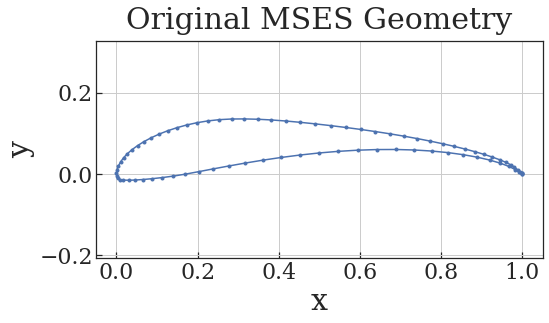

In [55]:
#PLOT ORIGINAL GEOMETRY
plt.figure(figsize=(8,4))
plt.title('Original MSES Geometry')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xgeom, ygeom, marker='.')
plt.axis('equal')
plt.show()

In the figure above, the original XFOIL geometry coordinates are represented with small circles.  Our goal in this demo will be to reconfigure these points to obtain our desired number of panels while still preserving our geometry.

## Point Redistribution Function

Now will will use linear interpolation to select new points to define our panel geometry. First, let's start by representing our airfoil with 10 panels (quite a coarse discretization).

Let's define the input parameters for this discretization:

In [56]:
#Number of panels in geometry discretization
Npanel = 10

In order to successfully interpolate our parametric coordinate data into fewer points, we will need to separate the upper and lower surfaces.  This process is achieved using the following functions and their usage is detailed in the MSES demo.

In [57]:
#MSES FILE FORMAT MANIPULATION FILES (SEE MSES DEMO)

def FindLE_top(X):
    """Return index dividing upper and lower surface given MSES geometry.
    Search along upper surface until LE.
    MSES files start at rear of airfoil, and x diminishes until the leading
    edge, where it then increases back to the trailing edge.  This code finds
    the transition where x goes from decreasing to increasing.
    X --> MSES x coordinates
    """
    xold = X[0]
    for i, x in enumerate(X[1:]):
        if x >= xold:
            #If current x greater/equal to prev x, x is increasing (lower surf)
            return i #return index of Leading Edge (divides upper/lower surfs)
        else:
            #If current x less than prev x, x still diminishing (upper surf)
            xold = x

def FindLE_bot(X):
    """Return index dividing upper and lower surface given MSES geometry.
    Search along lower surface until LE.
    MSES files start at rear of airfoil, and x diminishes until the leading
    edge, where it then increases back to the trailing edge.  This code finds
    the transition where x goes from decreasing to increasing.
    X --> MSES x coordinates
    """
    Xreverse = X[::-1]
    xold = Xreverse[0]
    for i, x in enumerate(Xreverse[1:]):
        if x >= xold:
            #If current x greater/equal to prev x, x is increasing (on upper surf)
            return len(X) - 1 - i #return index of Leading Edge (divides upper/lower surfs)
        else:
            #If current x less than prev x, x still diminishing (still on lower surf)
            xold = x

def MsesSplit(x, y):
    """Split MSES format into upper and lower surfaces.
    Find LE from MSES x geometry coordinates,
    Split y at this index(s).
    If LE point is at y=0, include in both sets of data.
    Return y split into upper/lower surfaces, with LE overlapping
    x --> MSES x coordinates
    y --> Any other MSES parameter (e.g. x/c, z/c, Cp, etc)
    """
    #FIND LE FROM BOTH SIDES (DETECT SHARED LE POINT)
    #Get index of leading edge starting from upper surface TE
    iLE_top = FindLE_top(x)
    #Get index of leading edge starting from lower surface TE
    iLE_bot = FindLE_bot(x)
    #Split upper and lower surface, reverse order upper surface
    up = y[iLE_top::-1]
    lo = y[iLE_bot:]
    return up, lo

def MsesInterp(xout, xmses, ymses):
    """Split MSES format data into upper and lower surfaces.  Then
    interpolate data to match given xout vector.
    xout  --> desired x locations
    xmses --> original x MSES data
    ymses --> original x/c, z/c, Cp, etc MSES data
    """
    xup_mses, xlo_mses = MsesSplit(xmses, xmses)
    yup_mses, ylo_mses = MsesSplit(xmses, ymses)
    yup = np.interp(xout, xup_mses, yup_mses)
    ylo = np.interp(xout, xlo_mses, ylo_mses)
    return yup, ylo

def MsesMerge(xlo, xup, ylo, yup):
    """ Merge separate upper and lower surface data into single MSES set.
    If LE point is shared by both sides, drop LE from lower set to avoid overlap
    xlo, xup --> lower/upper surface x coordinates to merge
    ylo, yup --> lower/upper surface y OR surface Cp values to merge
    """
    #drop LE point of lower surface if coincident with upper surface
    if xlo[0] == xup[0] and ylo[0] == yup[0]:
    # if xlo[0] == xup[0] and ylo[0] == 0 and yup[0] == 0:
        xlo = xlo[1:]
        ylo = ylo[1:]
    n1 = len(xup)     #number of upper surface points
    n = n1 + len(xlo) #number of upper AND lower surface points
    x, y = np.zeros(n), np.zeros(n)
    #reverse direction of upper surface coordinates
    x[:n1], y[:n1] = xup[-1::-1], yup[-1::-1]
    #append lower surface coordinates as they are
    x[n1:], y[n1:] = xlo, ylo
    return x, y

With our new MSES manipulation abilities, lets split our airfoil geometry into upper and lower surfaces, and discretize these separate surface into the approriate number of points to create our desired number of panels.

The following function will splits the airfoil surfaces and maps each to a new x-vector designed to produce the specified number of panels.  Additionally, the function manually shrinks the size of the panels at the trailing edge of the airfoil.  This will be important for the lifting panel code we will design later.

In [58]:
def ConstantSpacingAirfoil(xgeom, ygeom, n_panel, frac=0.25):
    """Creates airfoil panel points with uniform x-spacing.
    (Finer spacing at TE to enforce kutta).
    x, y    --> geometry coordinates (MSES format)
    n_panel --> number of panels to distretize into
    frac    --> Ratio of TE panel length to uniform spacing length
    """

    c = max(xgeom) - min(xgeom) #chord

    #Number of Panels On One Surface
    if n_panel%2 != 0:
        #odd number of panels
        Nsurf = (n_panel + 1) / 2
        Nsurf = int(Nsurf)
        xoffset = 1 #offset LE so we have flat LE
        print('\n\nConstant spacing with ODD # panels (Flat, vertical LE)\n\n')
        #                      _ _ _ _
        #                     /        \
        #              LE--> |          >  <--TE
        #                     \_ _ _ _ /
    else:
        #even number of panels
        Nsurf = (n_panel + 2) / 2
        Nsurf=int(Nsurf)
        xoffset = 0 #do not offset LE
        print('\n\nConstant spacing with EVEN # panels (Wedge-shape LE)\n\n')
        #                      _ _ _ _
        #                     /        \
        #              LE--> <          >  <--TE
        #                     \_ _ _ _ /

        
    #Trailing Edge Length
    TE_length = (frac * c) / (Nsurf + (frac - 1))

    #MAKE UNIFORM SPACING VECTOR FOR NON-TE PANELS
    #Start at some non-zero x for panel normal to flow in front at LE
    xLE = min(xgeom) + 0.001 * c * xoffset
    #End is where TE panels start
    xTE = max(xgeom) - TE_length
    #create x points
        #(number of points is half (one surface) of amount needed to end up
        #with n_panels after accounting for TE panels
    xnew = np.linspace(xLE, xTE, Nsurf-1)

    #ADD TE POINT (distance from xnew[-2] to xnew[-1] is TE_length)
    xnew = np.append(xnew, max(xgeom))

    #SPLIT AND INTERPOLATE GEOMETRY FOR NEW X-SPACING
    ynewup, ynewlo = MsesInterp(xnew, xgeom, ygeom)
    
    #MANAGE ODD/EVEN PANELS
        #Odd number of panels has vertical LE face
        #Even number of panels has pointy wedge LE face
    if xoffset == 0:
        #Only one point at LE, average y postition
        yLE = (ynewup[0] + ynewlo[0])/2
        #make upper surface have new LE point
        ynewup[0] = yLE
        #remove identical LE point from lower surface
        ynewlo = ynewlo[1:]
        xnewlo = xnew[1:]
    else:
        #lower x is the same as upper for odd number of panels
        xnewlo = np.array(xnew)
    
    #Merge new coordinates into one set
    xends, yends = MsesMerge(xnewlo, xnew, ynewlo, ynewup)

    return xends, yends

Using the discretization function, we can show our new panel points compared to our original geometry.



Constant spacing with EVEN # panels (Wedge-shape LE)




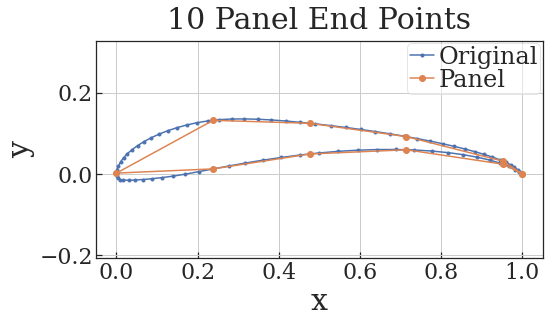

In [59]:
Npanel=10
#Calculate panel endpoints
xends, yends = ConstantSpacingAirfoil(xgeom, ygeom, Npanel, frac=0.25)

#Plot panel points and original geometry
plt.figure(figsize=(8,4))
plt.title('{} Panel End Points'.format(Npanel))
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xgeom, ygeom, marker='.', label='Original')
plt.plot(xends, yends, marker='o', label='Panel')
plt.axis('equal')
plt.legend()
plt.show()


From this point, you would use your panel code to connect the line between each point with a panel (see AeroPython).

The provided discretization function is capable of even and odd panel geometries.  The odd equivalent of the above discretization would be for 11 panels:



Constant spacing with ODD # panels (Flat, vertical LE)




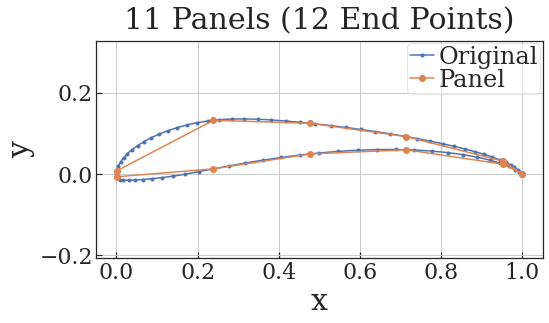

In [60]:
Npanel = 11
#Calculate panel endpoints
xends, yends = ConstantSpacingAirfoil(xgeom, ygeom, Npanel, frac=0.25)

#Plot panel points and original geometry
plt.figure(figsize=(8,4))
plt.title('{} Panels ({} End Points)'.format(Npanel, Npanel+1))
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xgeom, ygeom, marker='.', label='Original')
plt.plot(xends, yends, marker='o', label='Panel')
plt.axis('equal')
plt.legend()
plt.show()

Notice that now **the leading edge of the airfoil is a flat vertical face rather than a pointy wedge**.  This difference can have a significant effect on the performance of your panel method, depending on the specific situation, so pay attention to its affect in practice.

At this point, you may have noticed that the previous discretizations have been quite coarse.  Panels this large will lead to flow "leaking" around the control points, and decreasing the accuracy of the solution.  This can be improved by increasing the number of panels and, thus, the fidelity of our geometry model:



Constant spacing with ODD # panels (Flat, vertical LE)




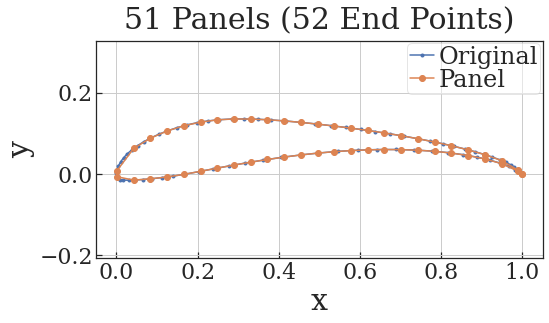

In [61]:
Npanel = 51
#Calculate panel endpoints
xends, yends = ConstantSpacingAirfoil(xgeom, ygeom, Npanel, frac=0.25)

#Plot panel points and original geometry
plt.figure(figsize=(8,4))
plt.title('{} Panels ({} End Points)'.format(Npanel, Npanel+1))
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xgeom, ygeom, marker='.', label='Original')
plt.plot(xends, yends, marker='o', label='Panel')
plt.axis('equal')
plt.legend()
plt.show()

We now have a much more realistic looking representation of our airfoil.  In the projects, you will experiment with the effect of panel spacing on the accuracy of the solution.